In [1]:
import numpy as np
import pandas as pd
import json
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib

# Font settings
font = {'size': 22}
matplotlib.rc('font', **font)

In [2]:
# Loading database
data_dir = "/bulk_materials/db/" # Specify your data path (Folder in which the files are placed)

In [3]:
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [4]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (2028, 5)


,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
0,W2S2,-31.329664,1,"(Atom('W', [1.52711328, 0.8816792633, 9.115147...",80.175958
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
2,Ti3F2N2,-55.546656,1,"(Atom('Ti', [0.0, 0.0, 11.208358341], index=0)...",155.068663
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
4,NbSTe,-19.876790,1,"(Atom('Nb', [1.26844161e-17, -3.001405002e-18,...",55.639070


In [5]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (264, 3)


,formula,etot,atoms
0,Ti2Te2,-21.567884,"(Atom('Te', [0.0001635792, 0.0005756553, 7.369..."
1,Cu2O2,-19.429111,"(Atom('Cu', [-3.606786318e-18, -0.0002926462, ..."
2,Y3C2,-33.214554,"(Atom('Y', [3.531761251e-18, -5.785592543e-18,..."
3,Ti2O4,-51.580206,"(Atom('Ti', [1.135647763e-19, 0.0301387729, 8...."
4,BiMoAs,-19.967820,"(Atom('Mo', [6.983934515e-18, 2.357780987e-16,..."


In [6]:
np.unique(train.dynamic_stability_level,return_counts=True)

(array([1, 2, 3]), array([ 469,  538, 1021]))

In [7]:
#functions to use
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat

In [8]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

12


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ase/atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


In [9]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
2000
2028


In [ ]:
#Setting target and feature vector

In [34]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (2028, 12)
y: (2028,)


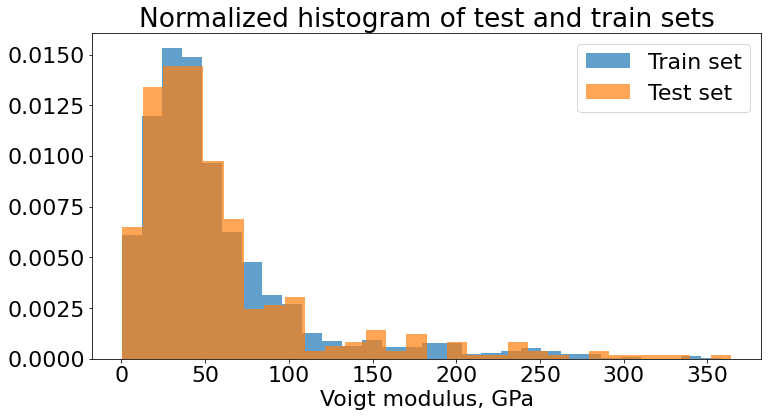

In [35]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=250)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()

In [49]:
###Sklearn Ridge Regression model###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import (Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30, normalize_y=True)


# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=30, normalize_y=True)

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [83]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [90]:
###Sklearn Ridge Regression model###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import (Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e3, 1e4)) * RBF(0.001, (1e-3, 0.1)) + RBF(0.001, (1e-3, 0.1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)


# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.001) + RBF(length_scale=0.001),
                         n_restarts_optimizer=20, normalize_y=True)

In [85]:
test_prediction = gp.predict(X_test)
train_prediction = gp.predict(X_train)

In [86]:
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 0.07
Test RMSE = 803.45


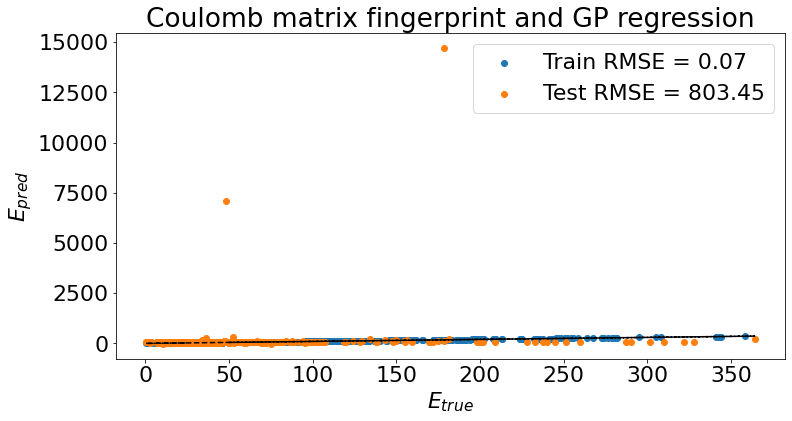

In [87]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and GP regression")
plt.scatter(y_train, gp.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, gp.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()

In [42]:
cmats_test = np.zeros((len(test),max_number_of_atoms))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats_test[i,:] = cmat.flatten()
print(len(cmats))

0
2028


In [26]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.index)
#X_test_kaggle.loc[:,:] = scaler.transform(X_test_kaggle)
X_test_kaggle.loc[:,:] = X_test_kaggle
X_test_kaggle.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,7239.873273,6001.878877,892.757174,666.358711,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1912.160496,1350.209177,72.880173,45.896580,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,4080.241306,3015.814703,2791.543355,38.617453,24.982962,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1048.979652,674.094258,84.285147,55.515745,54.039122,43.687835,0.0,0.0,0.0,0.0,0.0,0.0
4,20284.696226,3982.509533,2043.563134,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
                                                 'Voigt_modulus':gp.predict(X_test_kaggle)})
test_prediction_dataframe.head()

,ID,Voigt_modulus
0,0,34.245910
1,1,109.697157
2,2,103.335643
3,3,113.673490
4,4,37.811188


In [47]:
test_prediction_dataframe.to_csv(data_dir+'submission_test3.csv',index=False)

In [ ]:
##gaussian models##

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
#basic parameters
l = 1.5
k0 = 0.5
sigma = 0.005
x = X_train
xp = y_train
grid = X_test

In [ ]:
class GP:
    "Class used for training and predicting using Gaussian process"
    def __init__ (self, l, k0, sigma): 
        self.l = l
        self.k0 = k0
        self.sigma = sigma
    def kernel(self, x, xx):
        "Calculates kernel"
        return np.exp(-(np.sum((x-xx)**2))/(2*self.l**2))

    def kvec(self, x):
        "calculates k-vector, x  is grid values"
        kvec = np.array([self.kernel(x,xx) for xx in xp])
        return kvec
    
    def calc_K(self, xp):
        "Calculates K matrix. xp is samples x-values"
        K =  np.array([[self.kernel(x,xx) for x in xp] for xx in xp])
        return K
    
    def calc_C(self, xp):
        "Calculates C matrix. xp is sample x-values"
        K = self.calc_K(xp)
        C = K + self.sigma**2*np.identity(len(xp))
        return C
    
    def fitf(self, x, Cinvt):
        "returns k-vector dotted with C_inv dot sample-y"
        return np.dot(self.kvec(x), Cinvt)
    
    def varx(self, x, Cinv):
        "Calculates the variance. Used as descriptor for errousness"
        return self.kernel(x,x)-np.dot(self.kvec(x), np.dot(Cinv, self.kvec(x)))
    
    def train(self, xp):
        "xp is x-values of samples, tp is y-values of samples. Returns C invers and C invers dotted with t"
        C = self.calc_C(xp)
        return C
   
    def predict(self, xp, tp, grid):
        "xp is x-values of sample points, tp is y-values of sample points, grid is the grid to be fitted to"
        C = self.train(xp)
        Cinv = np.linalg.inv(C)
        Cinvt = np.dot(Cinv, tp)
        fit_array = np.array([self.fitf(x, Cinvt) for x in grid])
        var_array = np.array([self.varx(x, Cinv) for x in grid])
        return fit_array, ar_array

In [19]:
class GP:
    "Class used for training and predicting using Gaussian process"
    def __init__ (self, l, k0, sigma): 
        self.l = l
        self.k0 = k0
        self.sigma = sigma
       
    def calc_K(self, x_data1, x_data2):
        #x_data1 = x_data1.reshape(-1,1)
        #x_data2 = x_data2.reshape(-1,1)
        dist = np.sum(x_data1**2,axis=1).values.reshape(-1,1)+np.sum(x_data2**2,axis=1)-2*np.dot(x_data1, x_data2.T)
        K = self.k0*np.exp(-0.5*(dist)/(self.l)**2)
        #K =  np.array([[self.kernel(x,xx) for x in xp] for xx in xp])
        return K
    
    def calc_C(self, x_train):
        "Calculates C matrix. xp is sample x-values"
        K = self.calc_K(x_train,x_train)
        C = K + self.sigma**2*np.identity(len(K))
        return C
    
    def train(self, x_train, y_train):
        "xp is x-values of samples, tp is y-values of samples. Returns C invers and C invers dotted with t"
        C = self.calc_C(x_train)
        Cinv = np.linalg.inv(C)
        coef = np.matmul(Cinv, y_train.reshape(-1,1)) #didnt take yp into account
        return coef
   
    def predict(self, x_test, x_train, y_train):
        "xp is x-values of sample points, tp is y-values of sample points, grid is the grid to be fitted to"
        coef = self.train(x_train, y_train)
        k_mat_test = self.calc_K(x_test, x_train)
        return np.matmul(k_mat_test, coef)

In [20]:
model = GP(l,k0,sigma)

In [28]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
print(X[4])
print(y[1])

X: (2028, 12)
y: (2028,)
0          0.000000
1          0.000000
2         81.615493
3         83.367281
4          0.000000
           ...     
2023       0.000000
2024    1138.524096
2025    1165.207520
2026      26.432245
2027       0.000000
Name: 4, Length: 2028, dtype: float64
31.3588170028


In [128]:
model.train(X, y)

ValueError: Data must be 1-dimensional